# TPS-DEC2021[TPS-12/21[Xgb-optuna-tutorial+(study vis)]]

## Dataset


The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. This dataset is based off of the original Forest Cover Type Prediction competition

# Table of Contents
<a id="toc"></a>
- [1. Imports](#1)
- [2. Redcuce memory function](#2)
- [3. Load Data](#3)
- [4. Feature Eng..](#4)
- [5. Optuna objective function](#5)
- [6. Params Explanation](#6)
- [7. Dataframe of trails](#7)
- [8. Best params on 20 trails](#8)
- [9. Study Visualizations](#9)

.
## Observations
- num_classes = 6( dropped 1)
- Highly Imbalanced dataset, with soil type 5 having only 1 example
- Saw some correlations among the features with Elavation having a high Correlation with the target variable
- No of trails - 20

### Contact

- [Click here ](https://twitter.com/bambose_) - to connect me on twitter
- [14 baseline models](https://www.kaggle.com/datastrophy/tps-end-of-the-year-14-baseline-models/edit/run/81296449) - to visit the previous notebook


### PS - Ensemble notebook and training with best params notebook out soon






<a id="1"></a>
## Imports

In [ ]:
import pandas as pd
import datatable as dt
import numpy as np
import xgboost as xgb
import optuna
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
import plotly.express as px
from sklearn.model_selection import train_test_split
#from optuna.visualization import plot_edf
#from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

<a id="2"></a>
## Reduce memory function

In [ ]:
#No idea who is the creator of the function, very grateful. do let me know if you know the OG.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="3"></a>
## Load data

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")

In [ ]:
#Cover_type=5 has only one example, can drop it
train = train[train.Cover_Type != 5]                                                                       

<a id="4"></a>
## Feature Eng..

In [ ]:
#Thanks to this thread https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/293612
# remove unuseful features
train = train.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1)
test = test.drop(['Soil_Type7', 'Soil_Type15'], axis=1)

# extra feature engineering
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

def fe(df):
    df['EHiElv'] = df['Horizontal_Distance_To_Roadways'] * df['Elevation']
    df['EViElv'] = df['Vertical_Distance_To_Hydrology'] * df['Elevation']
    df['Aspect2'] = df.Aspect.map(r)
    ### source: https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/293373
    df["Aspect"][df["Aspect"] < 0] += 360
    df["Aspect"][df["Aspect"] > 359] -= 360
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    ########
    df['Highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    df['EVDtH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
    df['EHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    df['Euclidean_Distance_to_Hydrolody'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)**0.5
    df['Manhattan_Distance_to_Hydrolody'] = df['Horizontal_Distance_To_Hydrology'] + df['Vertical_Distance_To_Hydrology']
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    df['Hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    return df

train = fe(train)
test = fe(test)

# Summed features pointed out by @craigmthomas (https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/292823)
soil_features = [x for x in train.columns if x.startswith("Soil_Type")]
wilderness_features = [x for x in train.columns if x.startswith("Wilderness_Area")]

train["soil_type_count"] = train[soil_features].sum(axis=1)
test["soil_type_count"] = test[soil_features].sum(axis=1)

train["wilderness_area_count"] = train[wilderness_features].sum(axis=1)
test["wilderness_area_count"] = test[wilderness_features].sum(axis=1)


In [ ]:
y = train.Cover_Type.values - 1
X = reduce_mem_usage(train.drop("Cover_Type", axis=1)).set_index("Id")
Xtest = reduce_mem_usage(test).set_index("Id")

In [ ]:
import gc
del([train, test])
_ = [gc.collect() for i in range(5)]

In [ ]:
X

<a id="5"></a>
## Optuna objective function

In [ ]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.15,random_state=42)
        
    params = {
        'objective': trial.suggest_categorical('objective',['multi:softprob']), 
        'num_class': trial.suggest_categorical('num_class',[6]), 
        'tree_method': trial.suggest_categorical('tree_method',['gpu_hist']),
        'lambda': trial.suggest_loguniform('lambda',1e-3,10.0),
        'alpha': trial.suggest_loguniform('alpha',1e-3,10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3,1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001,0.1),
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13,15,17,20]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1,300),
        'eval_metric': trial.suggest_categorical('eval_metric',['mlogloss']),

    }
    model = xgb.XGBClassifier(**params)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=300,verbose=False)
    predictions = model.predict(test_x)
    acc = accuracy_score(test_y, predictions)
    
    return acc

<a id="6"></a>
### Params Explnation
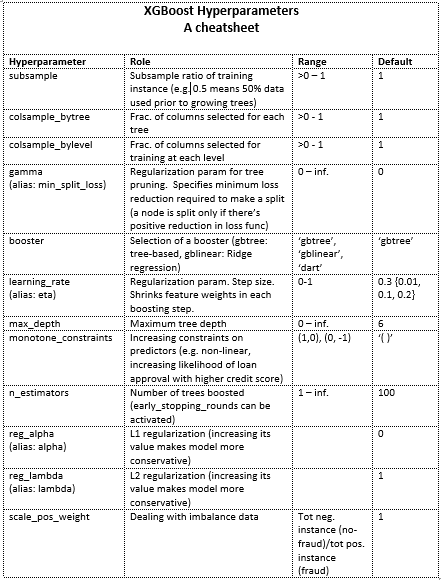

In [ ]:
%%time
study = optuna.create_study(direction = 'maximize' , study_name = 'xgbclassifier')
study.optimize(objective, n_trials=200)


In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

<a id="7"></a>
## Dataframe of trails

In [ ]:
df

In [ ]:
df.to_csv('df_xgb_params_200_trials.csv', index=False)

<a id="8"></a>
## Best params Optuna objective function

In [ ]:
study.best_trial.params

<a id="9"></a>
## Study visualizations

In [ ]:
#plots optimization history of all trials as well as the best score at each point.
plot_optimization_history(study)

In [ ]:
#plots the parameter relationship as slice also we can see which part of search space were explored more.
plot_slice(study)

In [ ]:
#plots the interactive visualization of the high-dimensional parameter relationship in study and scores.
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)